In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from torchvision.models import alexnet

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
# from imblearn.over_sampling import SMOTE
# from imblearn.combine import SMOTETomek
# from imblearn.under_sampling import TomekLinks

#from yellowbrick.model_selection import learning_curve


from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.utils import shuffle as shf
import pickle
import os
import glob as gb

## Loading and saving images as .npy files so we could deal with them

In [2]:
NORMAL = 'NORMAL'
BACTERIA = 'bacteria'
VIRAL = 'virus'
PNEUMONIA = 'PNEUMONIA'
code = {NORMAL:0 ,PNEUMONIA:1 }
#function to return the class of the images from its number, so the function would return 'Normal' if given 0, and 'PNEUMONIA' if given 1.
def getcode(n) : 
    for x , y in code.items() : 
        if n == y : 
            return x

In [46]:
#NOTE: This cell would only run properly if data is hosted locally

#the directory that contain the train images set
trainpath='chest_xray/test/'

X_train = []
y_train = []
for folder in  os.listdir(trainpath) : 
    files = gb.glob(pathname= str( trainpath + folder + '/*.jpeg'))
    for file in files: 
        # Read the image
        image = cv2.imread(file)
        
        # Convert the image to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Resize the grayscale image to 64x64 pixels
        resized_image = cv2.resize(gray_image, (64, 64))
        
        # Append the resized grayscale image to X_train
        X_train.append(resized_image)
        
        # Append the label to y_train
        y_train.append(code[folder])

np.save('X_test_gray',X_train)
np.save('y_test_gray',y_train)

In [57]:
#NOTE: This cell would only run properly if data is hosted locally

#the directory that contain the train images set
testpath='chest_xray/test/'

X_test = []
y_test = []
for folder in  os.listdir(testpath) : 
    files = gb.glob(pathname= str( testpath + folder + '/*.jpeg'))
    for file in files: 
        image = cv2.imread(file)
        #resize images to 64 x 64 pixels
        image_array = cv2.resize(image , (64,64))
        X_test.append(list(image_array))
        y_test.append(code[folder])
np.save('X_test',X_test)
np.save('y_test',y_test)

In [58]:
#NOTE: This cell would only run properly if data is hosted locally

#the directory that contain the train images set
testpath='chest_xray/val/'

X_val = []
y_val = []
for folder in  os.listdir(testpath) : 
    files = gb.glob(pathname= str( testpath + folder + '/*.jpeg'))
    for file in files: 
        image = cv2.imread(file)
        #resize images to 64 x 64 pixels
        image_array = cv2.resize(image , (64,64))
        X_val.append(list(image_array))
        y_val.append(code[folder])
np.save('X_val',X_val)
np.save('y_val',y_val)

## Loading the .npy files as numpy arrays


In [49]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Load preprocessed data

X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
X_train_3_labels = np.load('X_train_3_labels.npy')
y_train_3_labels = np.load('y_train_3_labels.npy')
X_train_gray = np.load('X_train_gray.npy')
y_train_gray = np.load('y_train_gray.npy')

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_train_tensor_3_labels = torch.tensor(X_train_3_labels, dtype=torch.float32).unsqueeze(1)  #
y_train_tensor_3_labels = torch.tensor(y_train_3_labels, dtype=torch.long)
X_train_tensor_gray = torch.tensor(X_train_gray, dtype=torch.float32)
Y_train_tensor_gray = torch.tensor(y_train_gray, dtype=torch.float32)

# Define dataset and dataloader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
train_dataset_3_labels = TensorDataset(X_train_tensor_3_labels, y_train_tensor_3_labels)
train_loader_3_labels = DataLoader(train_dataset_3_labels, batch_size=32, shuffle=True)
train_dataset_gray = TensorDataset(X_train_tensor_gray, Y_train_tensor_gray)
train_loader_gray = DataLoader(train_dataset_gray, batch_size=32, shuffle=True)

# Load preprocessed data
X_val = np.load('X_val.npy')
y_val = np.load('y_val.npy')
X_val_3_labels = np.load('X_val_3_labels.npy')
y_val_3_labels = np.load('y_val_3_labels.npy')
X_val_gray = np.load('X_test_gray.npy')
y_val_gray = np.load('y_test_gray.npy')

# Convert data to PyTorch tensors
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_val_tensor_3_labels = torch.tensor(X_val_3_labels, dtype=torch.float32)
y_val_tensor_3_labels = torch.tensor(y_val_3_labels, dtype=torch.long)
X_val_tensor_gray = torch.tensor(X_val_gray, dtype=torch.float32)
y_val_tensor_gray = torch.tensor(y_val_gray, dtype=torch.long)

# Define dataset and dataloader
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
val_dataset_3_labels = TensorDataset(X_val_tensor_3_labels, y_val_tensor_3_labels)
val_loader_3_labels = DataLoader(val_dataset_3_labels, batch_size=32, shuffle=True)
val_dataset_gray = TensorDataset(X_val_tensor_gray, y_val_tensor_gray)
val_loader_gray = DataLoader(val_dataset_gray, batch_size=32, shuffle=True)

# Load preprocessed data
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')
X_test_3_labels = np.load('X_test_3_labels.npy')
y_test_3_labels = np.load('y_test_3_labels.npy')

# Convert data to PyTorch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
X_test_tensor_3_labels = torch.tensor(X_test_3_labels, dtype=torch.float32)
y_test_tensor_3_labels = torch.tensor(y_test_3_labels, dtype=torch.long)

# Define dataset and dataloader
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
test_dataset_3_labels = TensorDataset(X_test_tensor_3_labels, y_test_tensor_3_labels)
test_loader_3_labels = DataLoader(test_dataset_3_labels, batch_size=32, shuffle=True)



In [4]:
import torch
import torch.nn.functional as F
import numpy as np

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Evaluate on test set
def evaluate_model(model, data_loader):
    _pred, _true = [], []
    model.eval()  # Set the model to evaluation mode
    test_loss, test_accuracy,num_samples  = 0.0, 0.0, 0.0
    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels  in data_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            _pred.extend(predicted.numpy())
            _true.extend(labels.numpy())
            num_samples += labels.size(0)
    test_loss /= num_samples
    test_accuracy = accuracy_score(_true, _pred)  
    return test_loss, test_accuracy

## Training AlexNet moodel  (1)

In [30]:
import os
import glob as gb
import cv2
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import tensorflow as tf

# Initialize lists to store training data
X_train = []
y_train = []

X_train = np.load('X_train_gray.npy')
y_train = np.load('y_train_gray.npy')


# Normalize the pixel values to range [0, 1]
X_train = X_train / 255.0


# Define the AlexNet model architecture
model = Sequential([
    Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=(64, 64, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(256, (5, 5), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(384, (3, 3), activation='relu', padding='same'),
    Conv2D(384, (3, 3), activation='relu', padding='same'),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

# # Compile the model
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# # Reshape input data to match model input shape
# X_train = X_train.reshape(-1, 64, 64, 1)

# # Train the model
# model.fit(X_train, y_train, epochs=10, batch_size=32)

# # Save the model
# model.save('alexnet_model.h5')

model = tf.keras.models.load_model('alexnet_model.h5')


c:\Users\Yuval\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [75]:

class AlexNet(nn.Module):
    def __init__(self, num_classes=2):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),  # Adjust input channels to 1
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=1, stride=1),
        )
        # Calculate the size of the flattened feature map
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Flatten(start_dim=1, end_dim=-1),
            nn.Dropout(p=0.3),
            nn.Linear(9216, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.Dropout(p=0.3),
            nn.Linear(128, num_classes),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = x.permute(0, 3, 1, 2)
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Create an instance of AlexNet
model = AlexNet()
# Training loop
num_epochs = 10
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, eps = 0.0001/num_epochs)

# # Train the model
# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0
#     for inputs, labels in train_loader:
#         #inputs = torch.cat([inputs] * 3, dim=1)
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item() * inputs.size(0)
#     epoch_loss = running_loss / len(train_dataset)
#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# # Save the trained model
# torch.save(model.state_dict(), 'alexnet_model_gray.pth')

model_path = "alexnet_model.pth"
model = AlexNet(num_classes=2)
model.load_state_dict(torch.load(model_path))
# Evaluate on test set
test_loss, test_accuracy = evaluate_model(model, test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

model_path = "alexnet_model_3_classes.pth"
model = AlexNet(num_classes=3)
model.load_state_dict(torch.load(model_path))
# Evaluate on test set
test_loss, test_accuracy = evaluate_model(model, test_loader_3_labels)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.4574, Test Accuracy: 0.8013
Test Loss: 0.9309, Test Accuracy: 0.7420


## Training ResNet moodel  (2)

In [76]:
import torch
import torch.nn as nn


# Define the Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

# Define the ResNet model
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=2):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Adjusted input channels to match the input data
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = x.permute(0, 3, 1, 2)  # Transpose input data to match the expected shape
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

# # Create an instance of ResNet
# model = ResNet(ResidualBlock, [2, 2, 2, 2], num_classes=3)

# # Training loop
# num_epochs = 10
# # Define loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.0001, eps = 0.0001/num_epochs)
# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0
#     for inputs, labels in train_loader_3_labels:
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item() * inputs.size(0)
#     epoch_loss = running_loss / len(train_dataset)
#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# # Save the trained model
# torch.save(model.state_dict(), 'ResNet_model_3_classes.pth')

model_path = "ResNet_model.pth"
model = ResNet(ResidualBlock, [2, 2, 2, 2], num_classes=2)
model.load_state_dict(torch.load(model_path))
# Evaluate on test set
test_loss, test_accuracy = evaluate_model(model, test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

model_path = "ResNet_model_3_classes.pth"
model = ResNet(ResidualBlock, [2, 2, 2, 2], num_classes=3)
model.load_state_dict(torch.load(model_path))
# Evaluate on test set
test_loss, test_accuracy = evaluate_model(model, test_loader_3_labels)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 1.5791, Test Accuracy: 0.7596
Test Loss: 2.0134, Test Accuracy: 0.6186


## Train VGG model

In [105]:
import torch
import torch.nn as nn

# Define VGG Block
class VGGBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_conv_layers):
        super(VGGBlock, self).__init__()
        layers = []
        for _ in range(num_conv_layers):
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            layers.append(nn.ReLU(inplace=True))
            in_channels = out_channels
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        self.vgg_block = nn.Sequential(*layers)

    def forward(self, x):
        return self.vgg_block(x)

# Define VGGNet
class VGGNet(nn.Module):
    def __init__(self, num_classes=3):
        super(VGGNet, self).__init__()
        self.features = nn.Sequential(
            VGGBlock(3, 64, 2),  # 64 channels, 2 convolutional layers
            VGGBlock(64, 128, 2), # 128 channels, 2 convolutional layers
            VGGBlock(128, 256, 3), # 256 channels, 3 convolutional layers
            VGGBlock(256, 512, 3), # 512 channels, 3 convolutional layers
            VGGBlock(512, 512, 3)  # 512 channels, 3 convolutional layers
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):    
        x = x.permute(0, 3, 1, 2)  # Transpose input data to match the expected shape
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Create an instance of VGGNet
model = VGGNet(num_classes=3)

# Training loop
num_epochs = 10
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, eps = 0.0001/num_epochs)
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# Save the trained model
torch.save(model.state_dict(), 'VGG_model.pth')

KeyboardInterrupt: 

## Task 2

In [101]:
import torch
import torchvision.transforms as transforms
from torchvision.models import alexnet
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from PIL import Image

def extract_features(model, image):

    with torch.no_grad():
        features = model(image)
    return features.numpy().squeeze()


# Load pre-trained AlexNet model
# model_path = "AlexNet_model.pth"
# alexnet_model = AlexNet(num_classes=2)
# alexnet_model.load_state_dict(torch.load(model_path))
#alexnet_model = alexnet(pretrained=True)

# Step 2: Extract features from your dataset
# Assuming you have a dataset of images stored in a list named 'dataset'
# Each element of 'dataset' is a tuple containing the image and its label
X_train = []
y_train = []
trainpath='chest_xray/train/'
# for folder in  os.listdir(trainpath) : 
#     files = gb.glob(pathname= str( trainpath + folder + '/*.jpeg'))
#     for file in files: 
#         #image = cv2.imread(file)
#         gray_image = Image.open(file).convert('L')

#         # Convert grayscale image to NumPy array
#         gray_image_np = np.array(gray_image)

#         features = extract_features(model, gray_image_np)

#         X_train.append(features)
#         y_train.append(code[folder])
for inputs, labels in train_loader:
    with torch.no_grad():
        features = model(inputs)
    X_train.append(features.numpy().squeeze())
    y_train.append(code[folder])

# Step 3: Train KNN classifier
# Flatten the input data
#print(X_train[0])
knn_classifier = KNeighborsClassifier(n_neighbors=5)
X_train_array = np.array(X_train)
print(X_train_array.shape)
X_train_reshaped = X_train_array.reshape(X_train_array.shape[0], -1)

print(X_train_reshaped.shape)
print(len(y_train))
knn_classifier.fit(X_train_reshaped, y_train)

# Step 4: Classify new images using KNN classifier
def classify_image(image):
    features = extract_features(model, image)
    predicted_label = knn_classifier.predict([features])[0]
    return predicted_label

# Example usage:
new_image_path = 'test.jpeg'
image = cv2.imread(new_image_path)
#resize images to 64 x 64 pixels
image_array = cv2.resize(image , (64,64))
image_tensor = torch.tensor(image_array, dtype=torch.float32)
predicted_class = classify_image(image_tensor)
print("Predicted class:", predicted_class)


# Visualize embedding vectors using t-SNE
def visualize_tsne(X, y):
    tsne = TSNE(n_components=2, perplexity=2, random_state=42)  # Adjust perplexity value
    t = torch.tensor(X)
    tsne_features = tsne.fit_transform(t.squeeze(0))
    plt.figure(figsize=(10, 8))
    for label in set(y):
        plt.scatter(tsne_features[y == label, 0], tsne_features[y == label, 1], label=label)
    plt.xlabel('t-SNE Feature 1')
    plt.ylabel('t-SNE Feature 2')
    plt.title('t-SNE Visualization')
    plt.legend()
    plt.show()

X_val_features = []
y_val_features = []
# Assuming you have a validation dataset stored in 'X_val' and 'y_val'
for inputs, labels in val_loader:
    with torch.no_grad():
        features = model(inputs)
        X_val_features.append(features.numpy().squeeze())
        y_val_features.append(labels)
#X_val_features = [extract_features(model, image) for image,_ in val_loader]
visualize_tsne(X_val_features, y_val_features)


(163, 32, 3)
(163, 96)
163


RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4

In [25]:
#X_train, X_test contain the images as numpy arrays, while y_train, y_test contain the class of each image 
loaded_X_train = np.load('C:/Users/Yuval/OneDrive/Documents/master/DL/X_train.npy')
loaded_y_train = np.load('C:/Users/Yuval/OneDrive/Documents/master/DL/y_train.npy')

loaded_X_test = np.load('C:/Users/Yuval/OneDrive/Documents/master/DL/X_test.npy')
loaded_y_test = np.load('C:/Users/Yuval/OneDrive/Documents/master/DL/y_test.npy')

In [26]:
print(loaded_X_train.shape)
#the shape return dimensions of X_train, we have 5216 images of 64 x 64 pixels. 
#while the forth dimension stores the RGB information of each pixel

(5216, 64, 64, 3)


In [27]:
print(loaded_X_test.shape)

(624, 64, 64, 3)


In [28]:
#y_train and y_test contain the labels of each image, whether 0 'NORMAL' or 1 'PNEUMONIA'
print(loaded_y_train.shape)
print(loaded_y_test.shape)

(5216,)
(624,)


## Flatten and shuffle train and test sets 

In [36]:
#flatten the images into a 2d array, for model training and testing
X_train = loaded_X_train.reshape([-1, np.product((64,64,3))])
X_test = loaded_X_test.reshape([-1, np.product((64,64,3))])

In [37]:
print(X_train.shape)
print(X_test.shape)

(5216, 12288)
(624, 12288)


In [38]:
y_train = loaded_y_train
y_test = loaded_y_test

In [39]:
#shuffle train and test data sets in a consistent way
X_train, y_train = shf(X_train, y_train, random_state=15)
X_test, y_test = shf(X_test, y_test, random_state=15)

## Testing classification algorithms without any preprocessing 

In [40]:
#making an instance of each algorithm
knn = KNeighborsClassifier(n_neighbors=10)
log_reg  = LogisticRegression()
dtc  = DecisionTreeClassifier()
rfc = RandomForestClassifier()
svm = SVC()

In [41]:
#fitting each model using X_train and y_train
knn.fit(X_train, y_train)
log_reg.fit(X_train, y_train)
dtc.fit(X_train, y_train)
rfc.fit(X_train, y_train)
svm.fit(X_train, y_train)

c:\Users\Yuval\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  args=(X, target, sample_weight, l2_reg_strength, n_threads),


SVC()

In [42]:
#scoring each model
print('KNN accuracy score is: ' + str(knn.score(X_test, y_test)))
print('Logistic Regression accuracy score is: ' + str(log_reg.score(X_test, y_test)))
print('Decision Tree Classifier accuracy score is: ' + str(dtc.score(X_test, y_test)))
print('Random forests Classifier accuracy score is: ' + str(rfc.score(X_test, y_test)))
print('Support Vector Machine Classifier accuracy score is: ' + str(svm.score(X_test, y_test)))

KNN accuracy score is: 0.7339743589743589
Logistic Regression accuracy score is: 0.7435897435897436
Decision Tree Classifier accuracy score is: 0.7371794871794872
Random forests Classifier accuracy score is: 0.7740384615384616
Support Vector Machine Classifier accuracy score is: 0.7612179487179487


The highest accuracy score obtaiend is from the random forests classifier. As accuracy score is not enough to judge a model we will use confusion matrix

In [50]:
#making predictions for each model
knn_predcited = knn.predict(X_test)
val_accuracy = accuracy_score(knn_predcited, y_test)
print("Validation Accuracy:", val_accuracy)

log_reg_predcited = log_reg.predict(X_test)
val_accuracy = accuracy_score(log_reg_predcited, y_test)
print("Validation Accuracy:", val_accuracy)

dtc_predcited = dtc.predict(X_test)
val_accuracy = accuracy_score(dtc_predcited, y_test)
print("Validation Accuracy:", val_accuracy)

rfc_predcited = rfc.predict(X_test)
val_accuracy = accuracy_score(rfc_predcited, y_test)
print("Validation Accuracy:", val_accuracy)

svm_predcited = svm.predict(X_test)
val_accuracy = accuracy_score(svm_predcited, y_test)
print("Validation Accuracy:", val_accuracy)

Validation Accuracy: 0.7339743589743589


In [44]:
#function to plot the confusion matrix for each model
def plot_cm(predictions, y_test, title):
  labels = ['Normal', 'Pnuemonia']
  cm = confusion_matrix(y_test,predictions)
  cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
  plt.figure(figsize = (7,7))
  plt.title(title)
  sns.heatmap(cm, linecolor = 'black' , linewidth = 1 , annot = True, fmt='', xticklabels = labels, yticklabels = labels)
  plt.show()

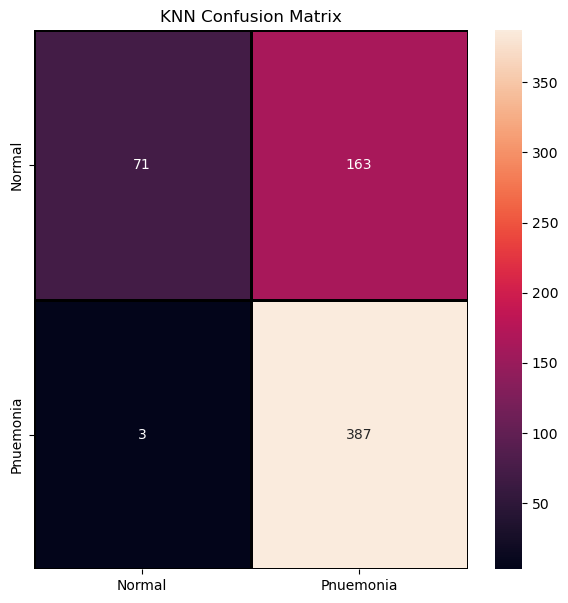

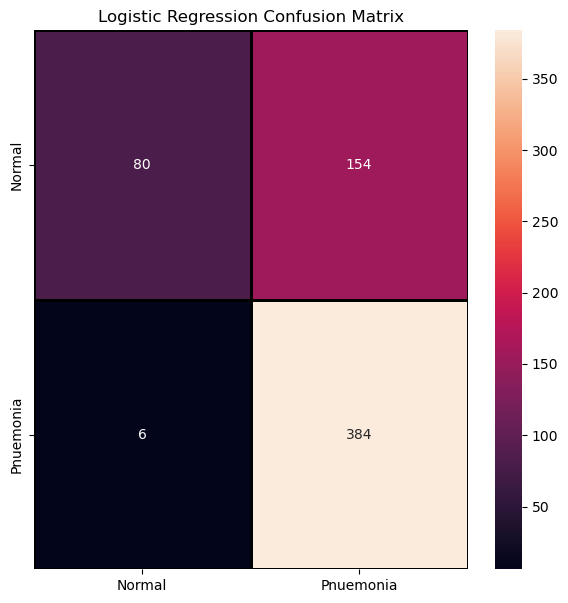

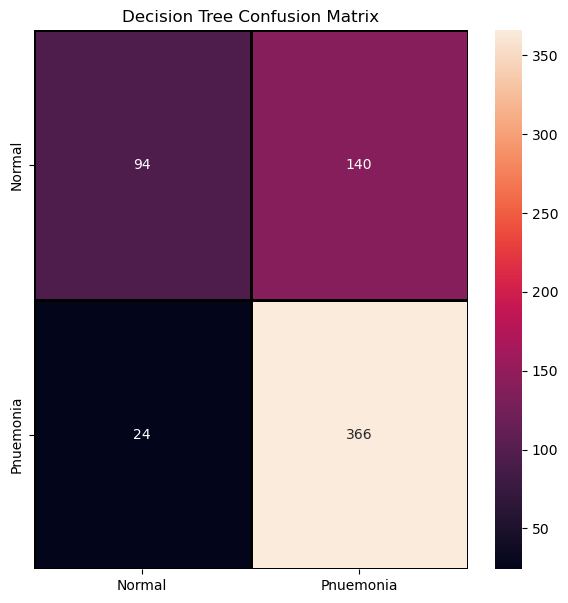

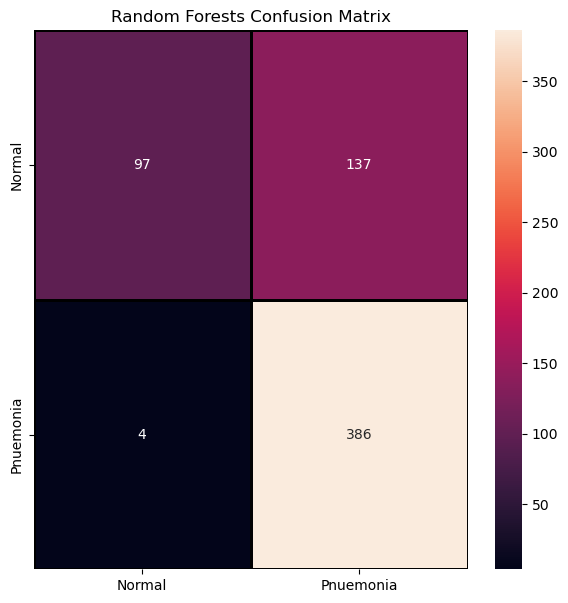

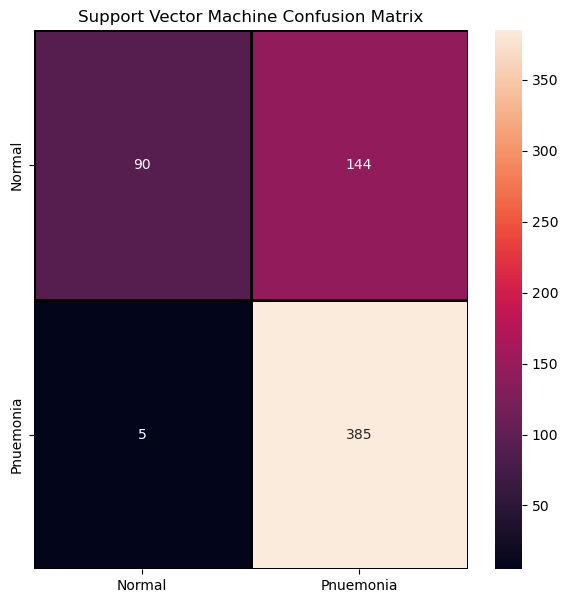

In [45]:
#plot confusion matrix for each model

plot_cm(knn_predcited, y_test, 'KNN Confusion Matrix')

plot_cm(log_reg_predcited, y_test, 'Logistic Regression Confusion Matrix') 
    
plot_cm(dtc_predcited, y_test, 'Decision Tree Confusion Matrix')

plot_cm(rfc_predcited, y_test, 'Random Forests Confusion Matrix')

plot_cm(svm_predcited, y_test, 'Support Vector Machine Confusion Matrix')

from looking at the confusion matrix we could say that the best classifier without any data preprofcessing is the random forests classifier.

## Data Preprocessing

Since our feaures are a representation of pixel values we will scale them

In [ ]:
#Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

we will use Principle Component Analysis (PCA) to reduce the amount of features, to n number of components that represent 0.95% variance of data  

In [ ]:
#PCA    
pca = PCA(.95)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [ ]:
#printing the variance of each component from PCA
print('Number of components after PCA: ' + str(pca.n_components_))

Number of components after PCA: 546


## Testing classification algorithms after scaling and PCA

In [ ]:
#making an instance for each algorithm
knn_PCA = KNeighborsClassifier(n_neighbors=10)
log_reg_PCA  = LogisticRegression()
dtc_PCA  = DecisionTreeClassifier()
rfc_PCA = RandomForestClassifier()
svm_PCA = SVC()

In [ ]:
#fitting each model using X_train and y_train
knn_PCA.fit(X_train, y_train)
log_reg_PCA.fit(X_train, y_train)
dtc_PCA.fit(X_train, y_train)
rfc_PCA.fit(X_train, y_train)
svm_PCA.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [49]:
#scoring each model
print('KNN accuracy score is: ' + str(knn_PCA.score(X_test, y_test)))
print('Logistic Regression accuracy score is: ' + str(log_reg_PCA.score(X_test, y_test)))
print('Decision Tree Classifier accuracy score is: ' + str(dtc_PCA.score(X_test, y_test)))
print('Random forests Classifier accuracy score is: ' + str(rfc_PCA.score(X_test, y_test)))
print('Support Vector Machine Classifier accuracy score is: ' + str(svm_PCA.score(X_test, y_test)))

NameError: name 'knn_PCA' is not defined

The highest accuracy score obtaiend is from the support vector machine. As accuracy score is not enough to judge a model we will use confusion matrix

In [48]:
#making predictions for each model
knn_PCA_predcited = knn_PCA.predict(X_test)

log_reg_PCA_predcited = log_reg_PCA.predict(X_test)
dtc_PCA_predcited = dtc_PCA.predict(X_test)
rfc_PCA_predcited = rfc_PCA.predict(X_test)
svm_PCA_predcited = svm_PCA.predict(X_test)

NameError: name 'knn_PCA' is not defined

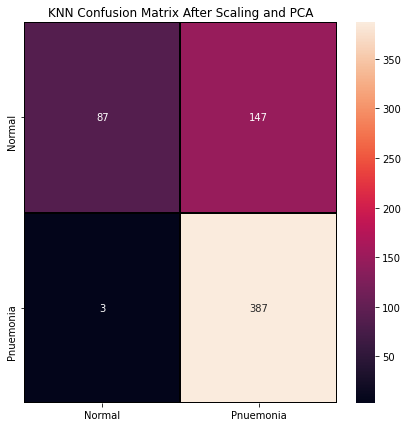

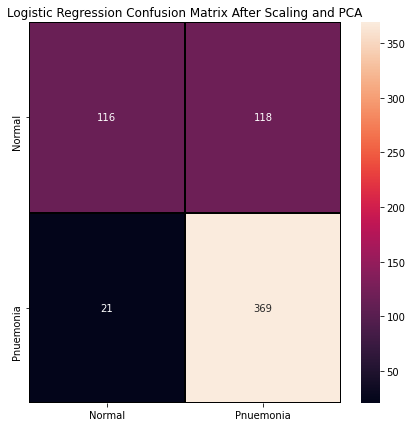

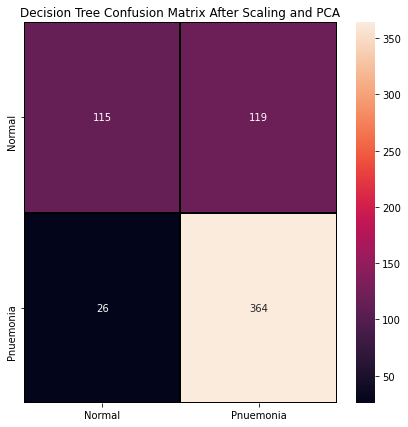

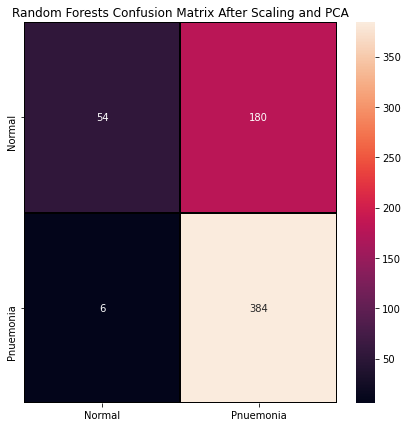

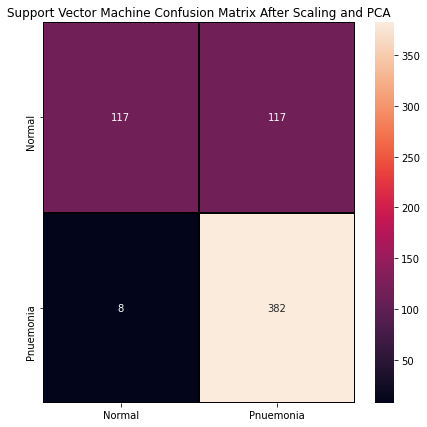

In [ ]:
#plot confusion matrix for each model after scaling and PCA

plot_cm(knn_PCA_predcited, y_test, 'KNN Confusion Matrix After Scaling and PCA')

plot_cm(log_reg_PCA_predcited, y_test, 'Logistic Regression Confusion Matrix After Scaling and PCA') 
    
plot_cm(dtc_PCA_predcited, y_test, 'Decision Tree Confusion Matrix After Scaling and PCA')

plot_cm(rfc_PCA_predcited, y_test, 'Random Forests Confusion Matrix After Scaling and PCA')

plot_cm(svm_PCA_predcited, y_test, 'Support Vector Machine Confusion Matrix After Scaling and PCA')

Since our data is imbalanced with pneumonia cases outnumbering normal cases, we will uses sampling techniques to try to overcome such imbalance

1 - Oversampling using SMOTE

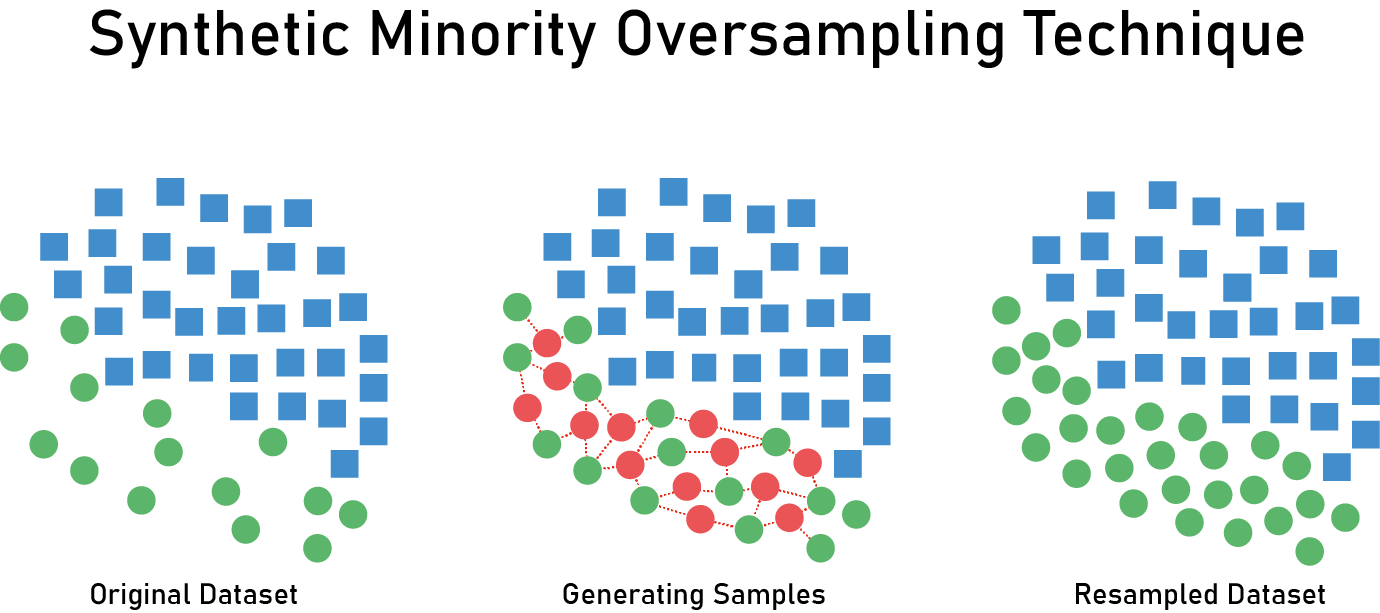

In [ ]:
#applying SMOTE to X_train and y_train to generate new samples to overcome the imbalance
smote = SMOTE(random_state = 11)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
#printing X_train and y_train shape after SMOTE
print(X_train_smote.shape)
print(y_train_smote.shape)

(7750, 546)
(7750,)


## Testing classification algorithms after SMOTE

In [ ]:
#making an instance for each algorithm
knn_smote = KNeighborsClassifier(n_neighbors=10)
log_reg_smote  = LogisticRegression()
dtc_smote  = DecisionTreeClassifier()
rfc_smote = RandomForestClassifier()
svm_smote = SVC()

In [ ]:
#fitting each model using X_train and y_train
knn_smote.fit(X_train_smote, y_train_smote)
log_reg_smote.fit(X_train_smote, y_train_smote)
dtc_smote.fit(X_train_smote, y_train_smote)
rfc_smote.fit(X_train_smote, y_train_smote)
svm_smote.fit(X_train_smote, y_train_smote)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
#scoring each model
print('KNN accuracy score is: ' + str(knn_smote.score(X_test, y_test)))
print('Logistic Regression accuracy score is: ' + str(log_reg_smote.score(X_test, y_test)))
print('Decision Tree Classifier accuracy score is: ' + str(dtc_smote.score(X_test, y_test)))
print('Random forests Classifier accuracy score is: ' + str(rfc_smote.score(X_test, y_test)))
print('Support Vector Machine Classifier accuracy score is: ' + str(svm_smote.score(X_test, y_test)))

KNN accuracy score is: 0.8237179487179487
Logistic Regression accuracy score is: 0.7836538461538461
Decision Tree Classifier accuracy score is: 0.7596153846153846
Random forests Classifier accuracy score is: 0.7371794871794872
Support Vector Machine Classifier accuracy score is: 0.8108974358974359


The highest accuracy score obtaiend is from the KNN. As accuracy score is not enough to judge a model we will use confusion matrix

In [47]:
#making predictions for each model
knn_smote_predcited = knn_smote.predict(X_test)


log_reg_smote_predcited = log_reg_smote.predict(X_test)
dtc_smote_predcited = dtc_smote.predict(X_test)
rfc_smote_predcited = rfc_smote.predict(X_test)
svm_smote_predcited = svm_smote.predict(X_test)

NameError: name 'knn_smote' is not defined

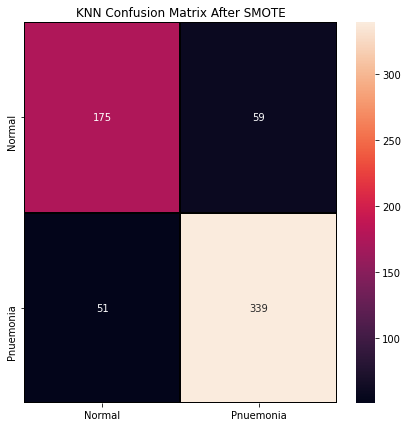

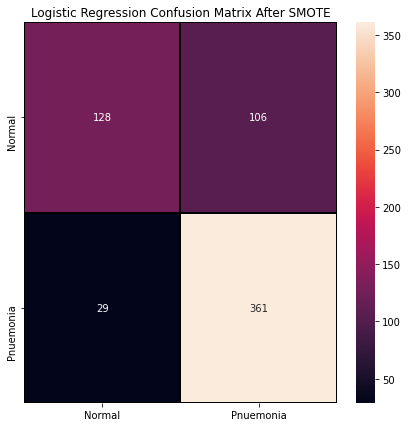

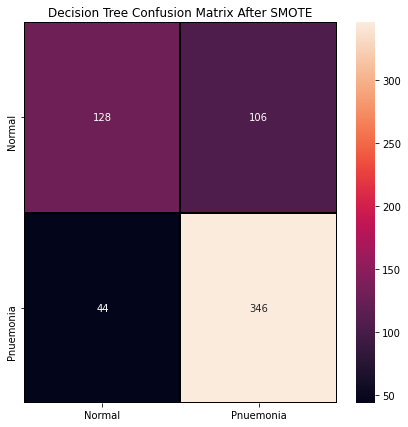

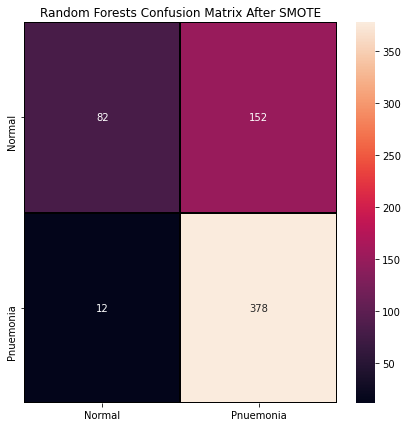

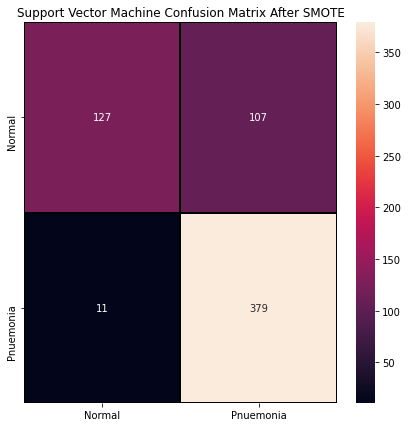

In [ ]:
#plot confusion matrix for each model after SMOTE

plot_cm(knn_smote_predcited, y_test, 'KNN Confusion Matrix After SMOTE')

plot_cm(log_reg_smote_predcited, y_test, 'Logistic Regression Confusion Matrix After SMOTE') 
    
plot_cm(dtc_smote_predcited, y_test, 'Decision Tree Confusion Matrix After SMOTE')

plot_cm(rfc_smote_predcited, y_test, 'Random Forests Confusion Matrix After SMOTE')

plot_cm(svm_smote_predcited, y_test, 'Support Vector Machine Confusion Matrix After SMOTE')

Looking at the confusion matrix of KNN and SVM models, it's hard to say which model is better as both models are good in certain areas and are flawed in others

2 SMOTE and TOMEK LINKS

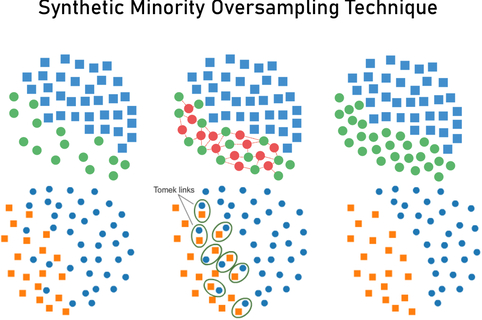

In [ ]:
#creating the resample object for SMOTE TOMEK LINKS
resample=SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))

In [ ]:
#fitting and resampling the SMOTETomek object to the train data
X_smote_tomek, y_smote_tomek= resample.fit_resample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
#printing shape of data from SMOTE and TOMEK LINKS
print(X_smote_tomek.shape)
print(y_smote_tomek.shape)

(7749, 546)
(7749,)


## Training classification Algorithms using data from SMOTE and TOMEK LINKS

In [ ]:
#making an instance for each algorithm
knn_smote_tomek = KNeighborsClassifier(n_neighbors=10)
log_reg_smote_tomek  = LogisticRegression()
dtc_smote_tomek  = DecisionTreeClassifier()
rfc_smote_tomek = RandomForestClassifier()
svm_smote_tomek = SVC()

In [ ]:
#fitting each model using data from SMOTE and TOMEK LINKS
knn_smote_tomek.fit(X_smote_tomek, y_smote_tomek)
log_reg_smote_tomek.fit(X_smote_tomek, y_smote_tomek)
dtc_smote_tomek.fit(X_smote_tomek, y_smote_tomek)
rfc_smote_tomek.fit(X_smote_tomek, y_smote_tomek)
svm_smote_tomek.fit(X_smote_tomek, y_smote_tomek)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
#scoring each model
print('KNN accuracy score is: ' + str(knn_smote_tomek.score(X_test, y_test)))
print('Logistic Regression accuracy score is: ' + str(log_reg_smote_tomek.score(X_test, y_test)))
print('Decision Tree Classifier accuracy score is: ' + str(dtc_smote_tomek.score(X_test, y_test)))
print('Random forests Classifier accuracy score is: ' + str(rfc_smote_tomek.score(X_test, y_test)))
print('Support Vector Machine Classifier accuracy score is: ' + str(svm_smote_tomek.score(X_test, y_test)))

KNN accuracy score is: 0.8349358974358975
Logistic Regression accuracy score is: 0.7836538461538461
Decision Tree Classifier accuracy score is: 0.7564102564102564
Random forests Classifier accuracy score is: 0.7772435897435898
Support Vector Machine Classifier accuracy score is: 0.8076923076923077


The highest accuracy score obtaiend is from the KNN. As accuracy score is not enough to judge a model we will use confusion matrix

In [ ]:
#making predictions for each model
knn_smote_tomek_predcited = knn_smote_tomek.predict(X_test)
log_reg_smote_tomek_predcited = log_reg_smote_tomek.predict(X_test)
dtc_smote_tomek_predcited = dtc_smote_tomek.predict(X_test)
rfc_smote_tomek_predcited = rfc_smote_tomek.predict(X_test)
svm_smote_tomek_predcited = svm_smote_tomek.predict(X_test)

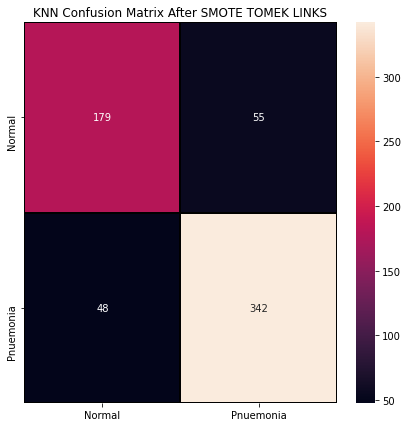

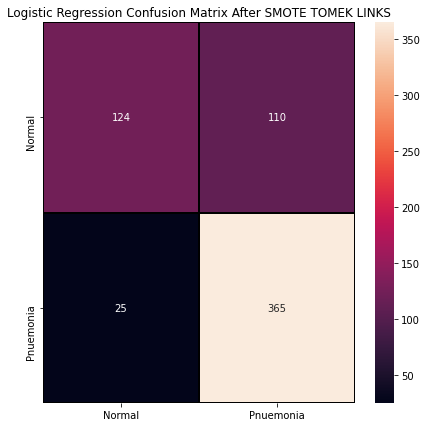

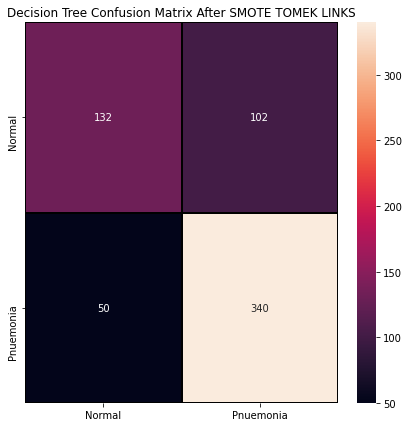

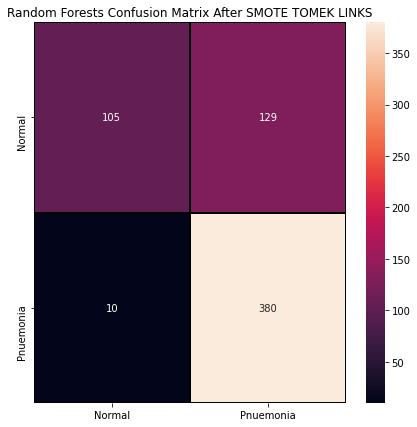

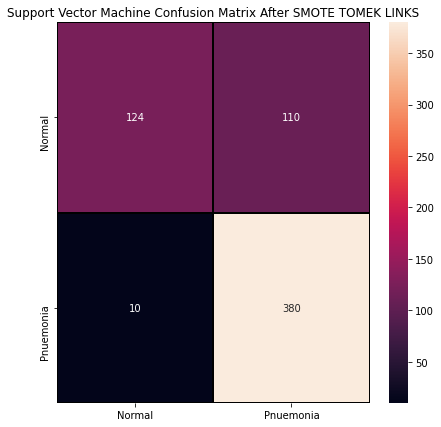

In [ ]:
#plot confusion matrix for each model after SMOTE

plot_cm(knn_smote_tomek_predcited, y_test, 'KNN Confusion Matrix After SMOTE TOMEK LINKS')

plot_cm(log_reg_smote_tomek_predcited, y_test, 'Logistic Regression Confusion Matrix After SMOTE TOMEK LINKS') 
    
plot_cm(dtc_smote_tomek_predcited, y_test, 'Decision Tree Confusion Matrix After SMOTE TOMEK LINKS')

plot_cm(rfc_smote_tomek_predcited, y_test, 'Random Forests Confusion Matrix After SMOTE TOMEK LINKS')

plot_cm(svm_smote_tomek_predcited, y_test, 'Support Vector Machine Confusion Matrix After SMOTE TOMEK LINKS')

The best results are obtained from KNN and SVM models

Printing the classification report for each of the two models to compare between them

In [ ]:
#KNN classification report 
print(classification_report(y_test, knn_smote_tomek_predcited, target_names= ['Normal (0)', 'Pneumonia (1)']))

               precision    recall  f1-score   support

   Normal (0)       0.79      0.76      0.78       234
Pneumonia (1)       0.86      0.88      0.87       390

     accuracy                           0.83       624
    macro avg       0.83      0.82      0.82       624
 weighted avg       0.83      0.83      0.83       624



In [ ]:
#SVM classification report 
print(classification_report(y_test, svm_smote_tomek_predcited, target_names= ['Normal (0)', 'Pneumonia (1)']))

               precision    recall  f1-score   support

   Normal (0)       0.93      0.53      0.67       234
Pneumonia (1)       0.78      0.97      0.86       390

     accuracy                           0.81       624
    macro avg       0.85      0.75      0.77       624
 weighted avg       0.83      0.81      0.79       624



We will try to optimize KNN and SVM model to select the best of them

## KNN Model Optimization

In [ ]:
#function to visualise the best K for the KNN model
def plot_K(X_train, y_train, X_test, y_test):
  error1= []
  error2= []
  for k in range(1,15):
    knn= KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    y_pred1= knn.predict(X_train)
    error1.append(np.mean(y_train!= y_pred1))
    y_pred2= knn.predict(X_test)
    error2.append(np.mean(y_test!= y_pred2))

  plt.plot(range(1,15),error1,label="train")
  plt.plot(range(1,15),error2,label="test")
  plt.xlabel('k Value')
  plt.ylabel('Error')
  plt.legend()

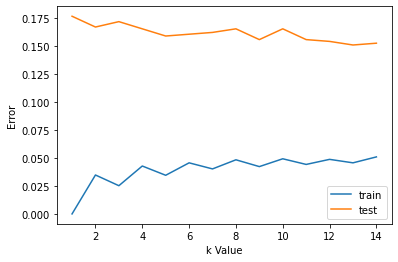

In [ ]:
plot_K(X_smote_tomek, y_smote_tomek, X_test, y_test)

from the graph the best k is 9

In [ ]:
#creating a KNN model with K = 9
KNN_model = KNeighborsClassifier(n_neighbors=9)
#fitting the model with the processed data
KNN_model.fit(X_smote_tomek, y_smote_tomek)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                     weights='uniform')

In [ ]:
#scoring the KNN model
print('KNN accuracy score is: ' + str(KNN_model.score(X_test, y_test)))

KNN accuracy score is: 0.844551282051282


In [ ]:
#making predictions for optimized KNN model
KNN_model_predcited = KNN_model.predict(X_test)

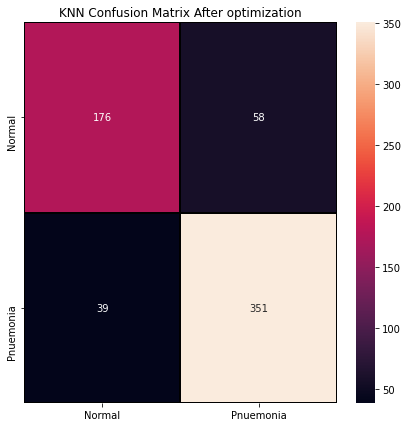

In [ ]:
#plot confusion matrix for KNN model

plot_cm(KNN_model_predcited, y_test, 'KNN Confusion Matrix After optimization')

# SVM Model Optimization

we will use grid search to try to optimize the SVM model

In [ ]:
#define the svm parameters for grid search
SVM_param_grid = { 
    'C':[0.1,1,100,1000],
    'kernel':['rbf','poly','sigmoid','linear'],
    'degree':[1,2,3,4,5,6],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001]
    }

In [ ]:
#creating the grid serach object
SVM_grid_search = GridSearchCV(svm_smote_tomek, param_grid = SVM_param_grid, cv = 3, verbose=True, n_jobs=-1, refit=True)

In [ ]:
#fitting the grid search object with processed data
SVM_grid_search.fit(X_smote_tomek, y_smote_tomek)

Fitting 3 folds for each of 480 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 24.6min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 56.2min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 98.8min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 154.6min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed: 179.0min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.1, 1, 100, 1000], 'degree': [1, 2, 3, 4, 5, 6],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'poly', 'sigmoid', 'linear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=True)

In [ ]:
#printing the best paramters from the SVM grid search
SVM_grid_search.best_params_

{'C': 100, 'degree': 1, 'gamma': 0.0001, 'kernel': 'rbf'}

In [ ]:
#getting the best model from the SVM grid search
best_SVM_model = SVM_grid_search.best_estimator_

In [ ]:
#scoring the best SVM model from grid search
print(best_SVM_model.score(X_test, y_test))

0.7996794871794872


as we can see the best model out of KNN and SVM models is the KNN one. Thusly, our project will run on the KNN model

## Evaluating the best model

In [ ]:
#scoring the KNN model
print('KNN accuracy score is: ' + str(KNN_model.score(X_test, y_test)))

KNN accuracy score is: 0.844551282051282


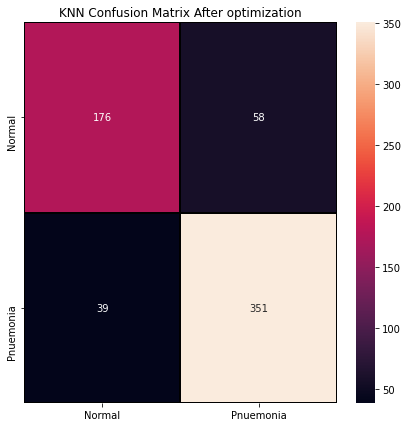

In [ ]:
#plot confusion matrix for KNN model

plot_cm(KNN_model_predcited, y_test, 'KNN Confusion Matrix After optimization')

In [ ]:
#printing the classification report
print(classification_report(y_test, KNN_model_predcited))

              precision    recall  f1-score   support

           0       0.82      0.75      0.78       234
           1       0.86      0.90      0.88       390

    accuracy                           0.84       624
   macro avg       0.84      0.83      0.83       624
weighted avg       0.84      0.84      0.84       624



Learning Curve of the KNN model

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


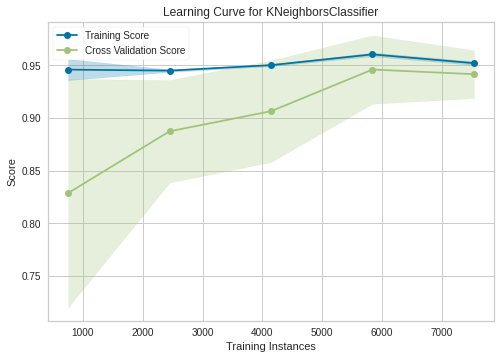

AxesSubplot(0.125,0.125;0.775x0.755)


In [ ]:
#creating two arrays that hold all the processed data and the labels respectively
X = np.concatenate((X_smote_tomek, X_test))
y = np.concatenate((y_smote_tomek, y_test))

#plot the learning curve
print(learning_curve(KNN_model, X, y, cv=10, scoring='accuracy'))

## Making Visualised Predictions 

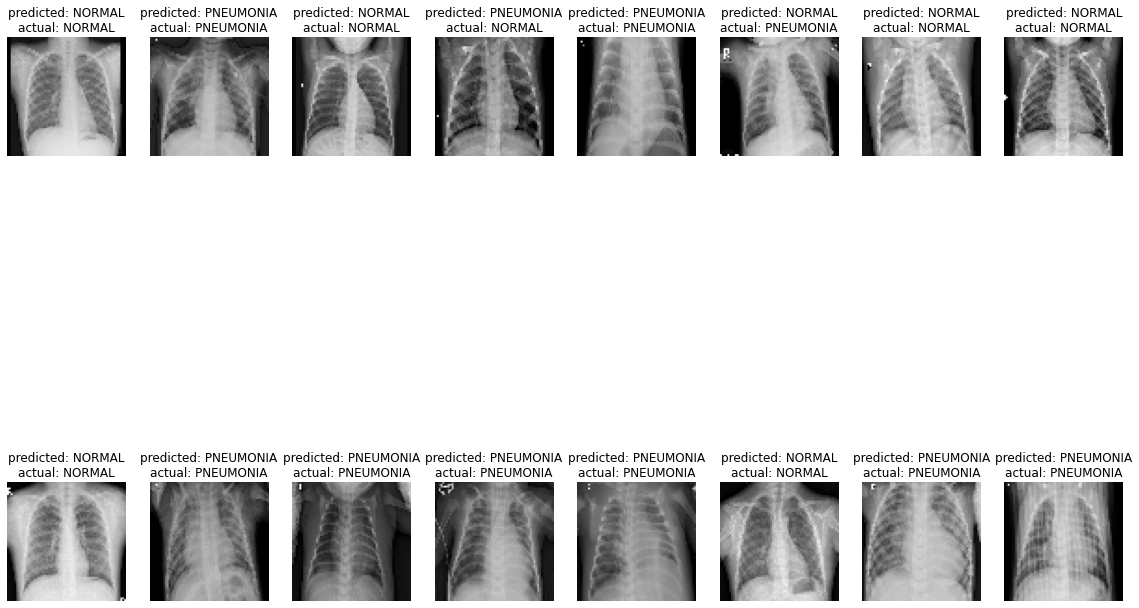

In [ ]:
#flatten
X_visual = loaded_X_test.reshape([-1, np.product((64,64,3))])

#scaling
X_visual = sc.fit_transform(X_visual)

#PCA
X_visual = pca.transform(X_visual)


#we pull 16 random images from the test data set and make predictions on them
plt.figure(figsize=(20,15))
for n , i in enumerate(np.random.randint(0,len(X_visual),16)):
    plt.subplot(2,8,n+1)
    plt.imshow(loaded_X_test[i])
    plt.axis('off')
    plt.title('predicted: ' + str(getcode(KNN_model.predict([X_visual[i]]))) + '\n' + 'actual: '  + str(getcode(loaded_y_test[i])))